In [14]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
from torch import tensor
import numpy as np
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import random
import os
import matplotlib.pyplot as plt
#from numba import jit
import pickle
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, random_split
import torch
from torchsummary import summary
import seaborn as sns
import sys
import torch.nn.functional as F
import pywt
from sklearn.preprocessing import MinMaxScaler
from torch.cuda import FloatTensor

# Req for package
sys.path.append("../")
from SkinLearning.NN.Helpers import train, test, DEVICE, getParameterLoss, setSeed
from SkinLearning.NN.Models import MultiTemporal
from SkinLearning.Utils.Dataset import getDataset, getSplit
from SkinLearning.Utils.Plotting import plotParameterBars, printCurves


torch.backends.cudnn.benchmark = True

In [3]:
setSeed()

In [4]:
# Remove one FC LAyer
class MultiRNN(nn.Module):
    def __init__(self, hidden_layers=256, single_fc=True, out="f_hidden"):
        super(MultiRNN, self).__init__()
        self.out = out
        
        self.conv1 = nn.Conv1d(2, 128, kernel_size=5, padding=1, bias=False)
        self.pool1 = nn.MaxPool1d(kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, padding=1, bias=False)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, padding=1, bias=False)
        
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.rnn = nn.RNN(15, hidden_layers, batch_first=True)
        
         
        input_tensor = torch.zeros(32, 512, 15)
        output, hidden = self.rnn(input_tensor)
        
        fc_in = hidden_layers
        if out == 'output':
            fc_in = output.shape[1] * output.shape[2]
        elif out == 'f-output':
            fc_in = output.shape[2]
        elif out == 'hidden':
            out = hidden_layers * output.shape[2]
        elif out == 'f-hiden':
            fc_in = output.shape[2]
        elif out == 'h+o':
            fc_in = output.shape[1]
            
        if single_fc:
            self.fc = nn.Linear(fc_in, 6)
        else:
            self.fc = nn.Sequential(
                nn.Linear(fc_in, 128),
                nn.ReLU(),
                nn.Linear(128 , 64),
                nn.ReLU(),
                nn.Linear(64, 6),   
            )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        
        #h0 = torch.zeros(1, batch_size, 256).to(x.device) 
        o, h = self.rnn(x)
        
        if self.out == "f_hidden":
            x = h[-1].reshape(batch_size, -1)
        elif self.out == "hidden":
            x = h.reshape(batch_size, -1)
        elif self.out == "f_output":
            x = o[:, -1, :].reshape(batch_size, -1)
        elif self.out == "output":
            x = o.reshape(batch_size, -1)
        elif self.out == "f_cell":
            x == c.reshape(batch_size, -1)
        elif self.out == "h+o":
            x = torch.concat([h[-1], o[:, -1, :]], dim=1).view(o.size(0), -1)
            
        x = self.fc(x)
        
        x = x.view(batch_size, 6)
        return x

In [5]:
dataset, scaler = getDataset()

100%|█████████████████████████████████████████████████████████████████████████████| 2241/2241 [00:09<00:00, 224.58it/s]


In [6]:
train_loader, test_loader = getSplit(dataset)

In [34]:
lstm1 = MultiTemporal(out="f_output", single_fc=False, temporal_type="LSTM")

In [35]:
train(train_loader, lstm1, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)

Using: cuda


 46%|█████████████▍               | 26/56 [00:00<00:00, 39.33batch/s, counter=0, epoch=6, lastLoss=0.115, valLoss=0.11]


KeyboardInterrupt: 

In [23]:
names = [
    "Output", "Hidden", "Final Hidden", "Final Output", "Final Output + Final Hidden"
]

single_fcs = [
    MultiRNN(out="output"),
    MultiRNN(out="hidden"),
    MultiRNN(out="f_hidden"),
    MultiRNN(out="f_output"),
    MultiRNN(out="h+o")
]

multi_fcs = [
    MultiRNN(out="output", single_fc=False),
    MultiRNN(out="hidden", single_fc=False),
    MultiRNN(out="f_hidden", single_fc=False),
    MultiRNN(out="f_output", single_fc=False),
    MultiRNN(out="h+o", single_fc=False)
]

In [24]:
single_fcs_train, single_fcs_val = [], []
multi_fcs_train, multi_fcs_val = [], []


for i, model in enumerate(single_fcs):
    print(f"Training single fc model {i}/{len(names)} using {names[i]}")
    train_loss, val_loss = train(train_loader, model, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)
    single_fcs_train.append(train_loss)
    single_fcs_val.append(val_loss)
    print("\n")

for i, model in enumerate(multi_fcs):
    print(f"Training multi fc model {i}/{len(names)} using {names[i]}")
    train_loss, val_loss = train(train_loader, model, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)
    multi_fcs_train.append(train_loss)
    multi_fcs_val.append(val_loss)
    print("\n")

Training single fc model 0/5 using Output
Using: cuda


 91%|█████████████████████████▌  | 51/56 [00:02<00:00, 25.39batch/s, counter=0, epoch=7, lastLoss=0.107, valLoss=0.102]


KeyboardInterrupt: 

In [8]:
single_fcs_train, single_fcs_val = [], []
multi_fcs_train, multi_fcs_val = [], []


for i, model in enumerate(single_fcs):
    print(f"Training single fc model {i}/{len(names)} using {names[i]}")
    train_loss, val_loss = train(train_loader, model, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)
    single_fcs_train.append(train_loss)
    single_fcs_val.append(val_loss)
    print("\n")

for i, model in enumerate(multi_fcs):
    print(f"Training multi fc model {i}/{len(names)} using {names[i]}")
    train_loss, val_loss = train(train_loader, model, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)
    multi_fcs_train.append(train_loss)
    multi_fcs_val.append(val_loss)
    print("\n")

Training single fc model 0/5 using Output
Using: cuda


100%|████████████████████████| 56/56 [00:00<00:00, 81.59batch/s, counter=11, epoch=67, lastLoss=0.0642, valLoss=0.0606]


 79%|██████████████████     | 44/56 [00:00<00:00, 79.11batch/s, counter=13, epoch=106, lastLoss=0.0587, valLoss=0.0572]


KeyboardInterrupt: 

In [14]:
import gc
torch.cuda.empty_cache()
gc.collect()

3304

In [9]:
single_fcs_train, single_fcs_val = [], []
multi_fcs_train, multi_fcs_val = [], []


for i, model in enumerate(single_fcs):
    print(f"Training single fc model {i}/{len(names)} using {names[i]}")
    train_loss, val_loss =train(train_loader, model, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)
    single_fcs_train.append(train_loss)
    single_fcs_val.append(val_loss)
    print("\n")

for i, model in enumerate(multi_fcs):
    print(f"Training multi fc model {i}/{len(names)} using {names[i]}")
    train_loss, val_loss = train(train_loader, model, val_loader=test_loader, LR=0.0001, epochs=1500, early_stopping=True)
    multi_fcs_train.append(train_loss)
    multi_fcs_val.append(val_loss)
    print("\n")

Training single fc model 0/5 using Output
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:00<00:00, 66.83batch/s, counter=0, lastLoss=0.0533, valLoss=0.0503]


Epoch 272/1500: 100%|██████████████████| 56/56 [00:01<00:00, 45.46batch/s, counter=10, lastLoss=0.0433, valLoss=0.0613]


Epoch 311/1500: 100%|██████████████████| 56/56 [00:01<00:00, 47.04batch/s, counter=49, lastLoss=0.0416, valLoss=0.0478]


Early stopping after 311 epochs
Average train loss: 0.012054264637952049
Average validation loss: 0.012308696554808153


Training single fc model 1/5 using Hidden
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:01<00:00, 48.80batch/s, counter=1, lastLoss=0.0575, valLoss=0.0554]


Epoch 272/1500: 100%|██████████████████| 56/56 [00:01<00:00, 50.43batch/s, counter=19, lastLoss=0.0508, valLoss=0.0526]


Epoch 365/1500: 100%|██████████████████| 56/56 [00:01<00:00, 49.38batch/s, counter=49, lastLoss=0.0445, valLoss=0.0461]


Early stopping after 365 epochs
Average train loss: 0.0147641609567661
Average validation loss: 0.014895482408379518


Training single fc model 2/5 using Final Hidden
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:01<00:00, 49.43batch/s, counter=9, lastLoss=0.0601, valLoss=0.0603]


Epoch 272/1500: 100%|███████████████████| 56/56 [00:01<00:00, 45.51batch/s, counter=3, lastLoss=0.0502, valLoss=0.0576]


Epoch 408/1500: 100%|██████████████████| 56/56 [00:01<00:00, 49.28batch/s, counter=20, lastLoss=0.0413, valLoss=0.0461]


Epoch 544/1500: 100%|███████████████████| 56/56 [00:01<00:00, 49.96batch/s, counter=8, lastLoss=0.0405, valLoss=0.0503]


Epoch 630/1500: 100%|███████████████████| 56/56 [00:01<00:00, 52.78batch/s, counter=49, lastLoss=0.0357, valLoss=0.042]


Early stopping after 630 epochs
Average train loss: 0.022324095141186953
Average validation loss: 0.023175434751518897


Training single fc model 3/5 using Final Output
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:01<00:00, 46.88batch/s, counter=4, lastLoss=0.0609, valLoss=0.0688]


Epoch 272/1500: 100%|███████████████████| 56/56 [00:01<00:00, 48.57batch/s, counter=6, lastLoss=0.0505, valLoss=0.0581]


Epoch 408/1500: 100%|██████████████████| 56/56 [00:01<00:00, 48.53batch/s, counter=22, lastLoss=0.0432, valLoss=0.0468]


Epoch 544/1500: 100%|███████████████████| 56/56 [00:01<00:00, 48.55batch/s, counter=7, lastLoss=0.0372, valLoss=0.0379]


Epoch 586/1500: 100%|██████████████████| 56/56 [00:01<00:00, 49.15batch/s, counter=49, lastLoss=0.0355, valLoss=0.0398]


Early stopping after 586 epochs
Average train loss: 0.02064709419315858
Average validation loss: 0.021527552770864634


Training single fc model 4/5 using Final Output + Final Hidden
Using: cuda:0


Epoch 136/1500: 100%|████████████████████| 56/56 [00:01<00:00, 52.68batch/s, counter=5, lastLoss=0.063, valLoss=0.0606]


Epoch 272/1500: 100%|███████████████████| 56/56 [00:01<00:00, 49.21batch/s, counter=42, lastLoss=0.0537, valLoss=0.052]


Epoch 406/1500: 100%|███████████████████| 56/56 [00:01<00:00, 47.64batch/s, counter=49, lastLoss=0.0452, valLoss=0.049]


Early stopping after 406 epochs
Average train loss: 0.0168036608503954
Average validation loss: 0.016830432990234758


Training multi fc model 0/5 using Output
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:01<00:00, 36.54batch/s, counter=3, lastLoss=0.0437, valLoss=0.0504]


Epoch 245/1500: 100%|███████████████████| 56/56 [00:01<00:00, 37.07batch/s, counter=49, lastLoss=0.035, valLoss=0.0398]


Early stopping after 245 epochs
Average train loss: 0.008513938730493898
Average validation loss: 0.009035766619423196


Training multi fc model 1/5 using Hidden
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:01<00:00, 53.56batch/s, counter=6, lastLoss=0.0589, valLoss=0.0584]


Epoch 272/1500: 100%|██████████████████| 56/56 [00:01<00:00, 50.09batch/s, counter=34, lastLoss=0.0464, valLoss=0.0515]


Epoch 408/1500: 100%|██████████████████| 56/56 [00:01<00:00, 50.31batch/s, counter=25, lastLoss=0.0389, valLoss=0.0507]


Epoch 432/1500: 100%|██████████████████| 56/56 [00:01<00:00, 49.80batch/s, counter=49, lastLoss=0.0357, valLoss=0.0476]


Early stopping after 432 epochs
Average train loss: 0.016002632422417045
Average validation loss: 0.01653877831974791


Training multi fc model 2/5 using Final Hidden
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:01<00:00, 48.80batch/s, counter=5, lastLoss=0.0573, valLoss=0.0573]


Epoch 272/1500: 100%|██████████████████| 56/56 [00:01<00:00, 50.56batch/s, counter=10, lastLoss=0.0481, valLoss=0.0499]


Epoch 408/1500: 100%|██████████████████| 56/56 [00:01<00:00, 48.82batch/s, counter=40, lastLoss=0.0388, valLoss=0.0472]


Epoch 544/1500: 100%|██████████████████| 56/56 [00:01<00:00, 52.02batch/s, counter=23, lastLoss=0.0354, valLoss=0.0467]


Epoch 620/1500: 100%|██████████████████| 56/56 [00:01<00:00, 50.04batch/s, counter=49, lastLoss=0.0329, valLoss=0.0383]


Early stopping after 620 epochs
Average train loss: 0.020516086152555155
Average validation loss: 0.021966544309879342


Training multi fc model 3/5 using Final Output
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:01<00:00, 52.81batch/s, counter=0, lastLoss=0.0622, valLoss=0.0552]


Epoch 272/1500: 100%|███████████████████| 56/56 [00:01<00:00, 54.69batch/s, counter=6, lastLoss=0.0496, valLoss=0.0498]


Epoch 408/1500: 100%|████████████████████| 56/56 [00:01<00:00, 55.72batch/s, counter=0, lastLoss=0.042, valLoss=0.0423]


Epoch 544/1500: 100%|██████████████████| 56/56 [00:01<00:00, 54.79batch/s, counter=44, lastLoss=0.0405, valLoss=0.0411]


Epoch 680/1500: 100%|██████████████████| 56/56 [00:01<00:00, 54.64batch/s, counter=34, lastLoss=0.0322, valLoss=0.0388]


Epoch 695/1500: 100%|██████████████████| 56/56 [00:01<00:00, 55.12batch/s, counter=49, lastLoss=0.0316, valLoss=0.0384]


Early stopping after 695 epochs
Average train loss: 0.022939543171697076
Average validation loss: 0.024260309676867393


Training multi fc model 4/5 using Final Output + Final Hidden
Using: cuda:0


Epoch 136/1500: 100%|███████████████████| 56/56 [00:01<00:00, 54.66batch/s, counter=4, lastLoss=0.0614, valLoss=0.0579]


Epoch 272/1500: 100%|██████████████████| 56/56 [00:00<00:00, 58.24batch/s, counter=48, lastLoss=0.0505, valLoss=0.0525]


Epoch 401/1500: 100%|██████████████████| 56/56 [00:01<00:00, 55.12batch/s, counter=49, lastLoss=0.0433, valLoss=0.0489]


Early stopping after 401 epochs
Average train loss: 0.016144544271197884
Average validation loss: 0.0164912858567718




In [20]:
def getParameterLoss(models, names, test_loader, scaler, output=False):
    params = []
    overall = []
    
    # Run evaluation on all models
    for model in models:
        avg, ps, _, = test(test_loader, model, scaler)
        overall.append(avg)
        params.append(ps)
    
    all_vals = np.array(params)
    df = pd.DataFrame({
        "Architecture": names,
        "YM (Skin)": all_vals[:, 0],
        "YM (Adipose)": all_vals[:, 1],
        "PR (Skin)": all_vals[:, 2],
        "PR (Adipose)": all_vals[:, 3],
        "Perm (Skin)": all_vals[:, 4],
        "Perm (Adipose)": all_vals[:, 5],
        "Overall": overall
    })
    
    df = df.set_index("Architecture")

    if output:
        df = df.style.set_caption(
            'Average percent correctness 100-MAPE').set_table_styles([{
            'selector': 'caption',
            'props': [
                ('color', 'black'),
                ('font-size', '16px'),
                ('text-align', 'center')
            ]
        }])

        display(df)
    else:
        return df

In [26]:
df = getParameterLoss(single_fcs, ["Single RNN "+name for name in names], test_loader, scaler)

100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 156.26 batch/s]


In [27]:
df2 = getParameterLoss(single_fcs, ["Multi RNN "+name for name in names], test_loader, scaler)

100%|█████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 162.15 batch/s]


In [28]:
df.to_csv("../Results/single_RNN.csv")

In [29]:
df2.to_csv("../Results/multi_RNN.csv")

In [25]:
import gc
torch.cuda.empty_cache()
gc.collect()

1956

In [52]:
rnns = pd.concat([df, df2])
grus = pd.concat([pd.read_csv("../Results/single_GRU.csv"), pd.read_csv("../Results/multi_GRU.csv")])
grus = grus.set_index("Architecture")
lstms = pd.concat([pd.read_csv("../Results/single_LSTM.csv"), pd.read_csv("../Results/multi_LSTM.csv")])
lstms = lstms.set_index("Architecture")

In [53]:
all_tests = pd.concat([rnns, grus, lstms])

In [54]:
all_tests

,YM (Skin),YM (Adipose),PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall
Architecture,,,,,,,
Single RNN Output,95.657333,83.311768,99.786163,99.775467,82.176826,94.077568,92.464190
Single RNN Hidden,94.821686,83.483696,99.746086,99.758415,77.016640,93.130058,91.326097
Single RNN Final Hidden,96.260246,83.411011,99.807129,99.767570,86.031021,95.029083,93.384344
Single RNN Final Output,96.167397,88.326836,99.810265,99.851242,85.325958,95.536537,94.169707
Single RNN Final Output + Final Hidden,94.995483,85.424469,99.751663,99.760674,70.952873,93.937248,90.803733
Multi RNN Output,95.083458,83.825958,99.776039,99.798889,82.060562,94.213654,92.459760
Multi RNN Hidden,94.922104,81.844330,99.745979,99.751053,77.306824,92.783745,91.059005
Multi RNN Final Hidden,96.215546,82.768829,99.807678,99.770767,86.050301,95.038742,93.275310
Multi RNN Final Output,96.169991,88.517921,99.788521,99.843826,80.085991,95.529968,93.322704


In [57]:
filt = all_tests[all_tests['Overall'].rank(method='first', ascending=False) <= 6]

In [108]:
filt

,YM (Skin),YM (Adipose),PR (Skin),PR (Adipose),Perm (Skin),Perm (Adipose),Overall
Architecture,,,,,,,
Single RNN Final Output,96.167397,88.326836,99.810265,99.851242,85.325958,95.536537,94.169707
Single GRU Final Hidden,95.926210,88.275390,99.805890,99.851340,86.666180,95.497230,94.337042
Multi GRU Output,96.316216,87.604650,99.810410,99.840970,86.052605,95.113830,94.123114
Multi GRU Hidden,96.186670,88.557274,99.795990,99.852930,86.015015,95.419754,94.304604
Multi GRU Final Output,95.330760,88.206180,99.768980,99.841910,84.988310,95.403015,93.923194
Multi LSTM Final Output,96.085976,87.055250,99.805824,99.845560,87.441376,96.494760,94.454791


C:\Users\rjsou\AppData\Local\Temp\ipykernel_19040\730531911.py:87: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(f'../Results/{fname}.svg', bbox_inches="tight" )
C:\Users\rjsou\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


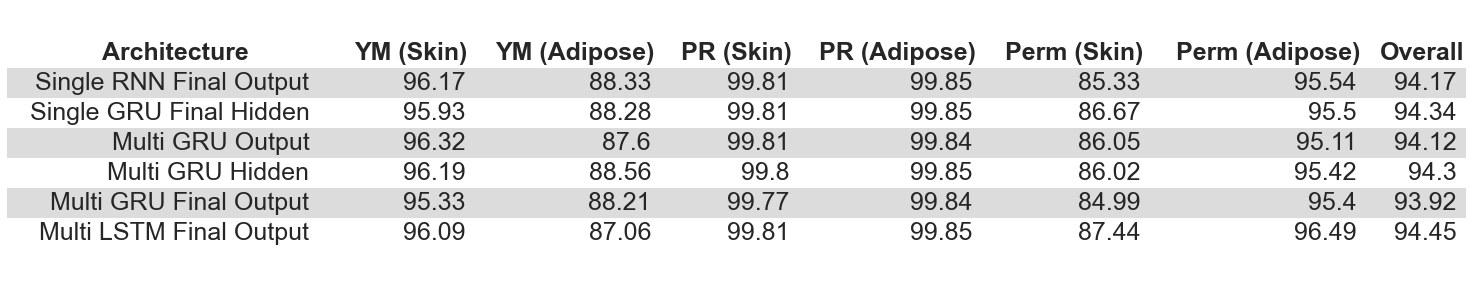

In [105]:
from matplotlib.font_manager import FontProperties
save_df(filt, fname="multitestsdf")

In [109]:
def plotParameterBars(df, file_name=None):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
    df.plot.bar(ax=ax)
    
    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=25)
    ax.set_ylabel("Architecture", fontsize=30)
    ax.set_xlabel("Accuracy (%)", fontsize=30)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),  prop={'size': 25})
    ax.set_title("Average percent correctness 100-MAPE", size=40, y=1.08)
    ax.set_ylim(80, 100)

    if file_name:
        fig.savefig(f"../Results/{file_name}", bbox_inches='tight')


"""
    Plots train/validation loss curves for the given models
"""
def printCurves(model_names, train_losses, val_losses, epochs=550, fname=None):
    assert len(model_names) == len(train_losses) == len(val_losses)
    
    num_plots = len(model_names)
    num_cols = 2 if num_plots >= 2 else 1
    num_rows = math.ceil(num_plots / num_cols)
    figsize = (20 * num_cols, 15 * num_rows)
    lines = []
    labels = []
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True)
    
    if num_rows == 1 and num_cols == 1:
        axes = [axes]

    for idx, ax in enumerate(axes.flatten()):
        if idx < num_plots:
            model_name = model_names[idx]
            train_loss = train_losses[idx]
            val_loss = val_losses[idx]
            epoch_range = range(0, epochs)

            line1, = ax.plot(epoch_range, train_loss, label='Train')
            line2, = ax.plot(epoch_range, val_loss, label='Validation')

            ax.set_title(model_name, fontsize=40)
            ax.tick_params(axis='both', labelsize=35)
            
                        
            if idx == 0:
                lines.extend([line1, line2])
                labels.extend(['Train', 'Validation'])
                
        else:
            ax.axis('off')

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    fig.suptitle('Epoch', fontsize=50, x=0.5, y=0.02, horizontalalignment='center', verticalalignment='bottom')
    fig.supylabel('MAE', fontsize=50, x=0.02, y=0.5, horizontalalignment='left', verticalalignment='center', rotation='vertical')
    fig.legend(lines, labels, prop={'size': 50})
    
    if not os.path.exists("../Results/"):
        os.makedirs("../Results/")
    
    if fname:
        plt.savefig(f"../Results/{fname}.svg", format='svg', bbox_inches='tight')
        
    plt.show()

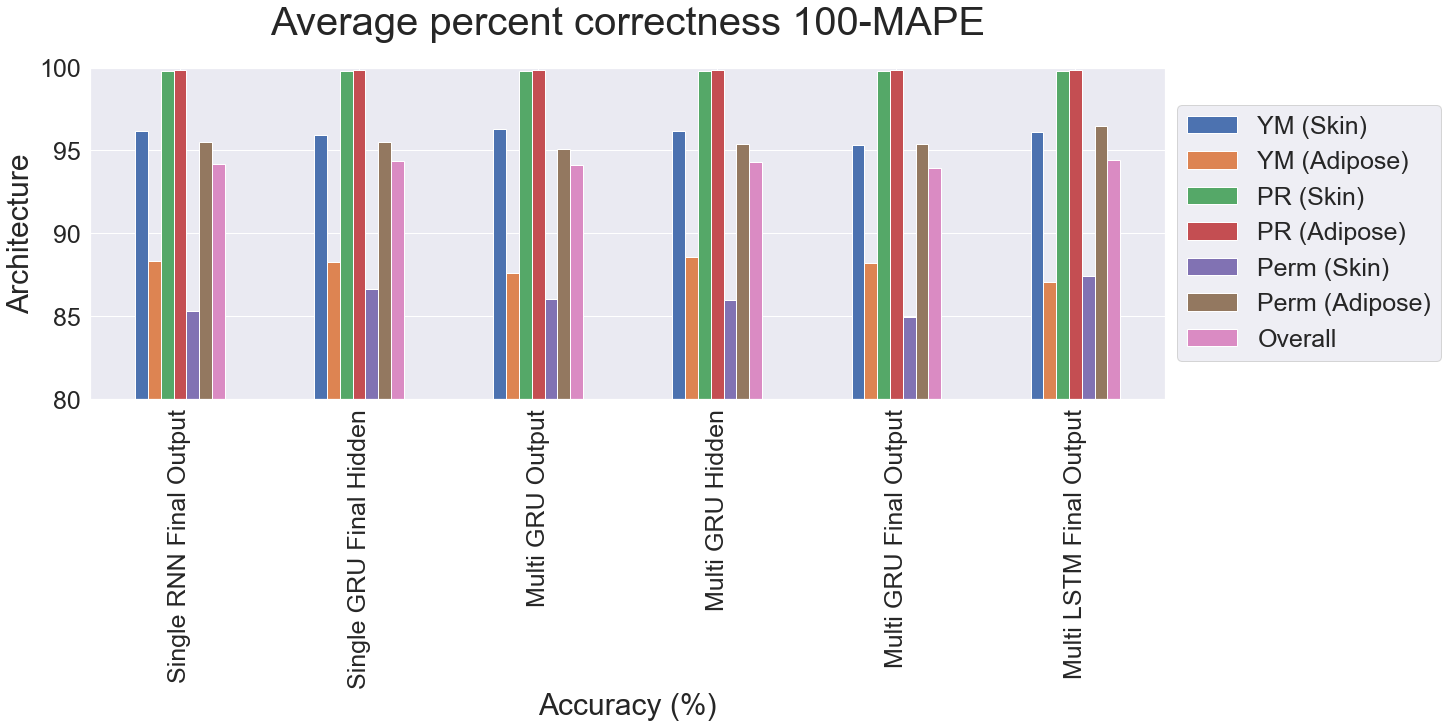

In [110]:
plotParameterBars(filt, file_name="multitestbars.svg")

In [93]:
import pickle

with open("../Results/GRUS_train_test", "rb") as f:
    trains, vals, names = pickle.load(f)
    
with open("../Results/LSTMS_train_test", "rb") as f:
    t, v, n = pickle.load(f)


In [94]:
names.append(n)
trains.append(t)
vals.append(v)

In [95]:
names.append("Single RNN Final Output")
trains.append(single_fcs_train[3])
vals.append(single_fcs_val[3])

In [102]:
def printCurves(model_names, train_losses, val_losses, epochs, fname=None):
    assert len(model_names) == len(train_losses) == len(val_losses)
    
    num_plots = len(model_names)
    num_cols = 2 if num_plots >= 2 else 1
    num_rows = math.ceil(num_plots / num_cols)
    figsize = (20 * num_cols, 15 * num_rows)
    lines = []
    labels = []
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    if num_rows == 1 and num_cols == 1:
        axes = [axes]

    for idx, ax in enumerate(axes.flatten()):
        if idx < num_plots:
            model_name = model_names[idx]
            train_loss = train_losses[idx]
            val_loss = val_losses[idx]
            epoch_range = range(0, epochs[idx])

            line1, = ax.plot(epoch_range, train_loss, label='Train')
            line2, = ax.plot(epoch_range, val_loss, label='Validation')

            ax.set_title(model_name, fontsize=40)
            ax.tick_params(axis='both', labelsize=35)
            
                        
            if idx == 0:
                lines.extend([line1, line2])
                labels.extend(['Train', 'Validation'])
                
        else:
            ax.axis('off')

    plt.subplots_adjust(hspace=0.2, wspace=0.1)
    fig.suptitle('Epoch', fontsize=50, x=0.5, y=0.02, horizontalalignment='center', verticalalignment='bottom')
    fig.supylabel('MAE', fontsize=50, x=0.02, y=0.5, horizontalalignment='left', verticalalignment='center', rotation='vertical')
    fig.legend(lines, labels, prop={'size': 50})
    
    if not os.path.exists("../Results/"):
        os.makedirs("../Results/")
    
    if fname:
        plt.savefig(f"../Results/{fname}.svg", format='svg', bbox_inches='tight')
        
    plt.show()

"""
    Plots and save a given dataframe
"""
def save_df(df, fname):
    fig = plt.figure(figsize=(5,5), frameon=False, constrained_layout=True)
    df = df.astype(float)
    df = df.round(2)

    labels = np.concatenate(([df.index.name], df.columns))
    text = np.hstack((df.index.values.reshape(-1, 1), df.values))
    
    table = plt.table(cellText = text, 
                      colLabels = labels,
                      loc='center',
                     )

    plt.axis('off')
    plt.grid('off')
    
    for (row, col), cell in table.get_celld().items():
        if row == 0 or col == -1:
            cell.set_text_props(fontproperties=FontProperties(weight='bold'))
        
        cell.set_edgecolor("none")

            
        if row %2 != 0:
            cell.set_facecolor('gainsboro')

        

    table.auto_set_font_size(False)
    table.set_fontsize(25)
    table.scale(2.5, 2.5)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    
    if fname:
        plt.savefig(f'../Results/{fname}.svg', bbox_inches="tight" )
    
    plt.show()

In [97]:
import math

In [98]:
epochs = [len(t) for t in trains]

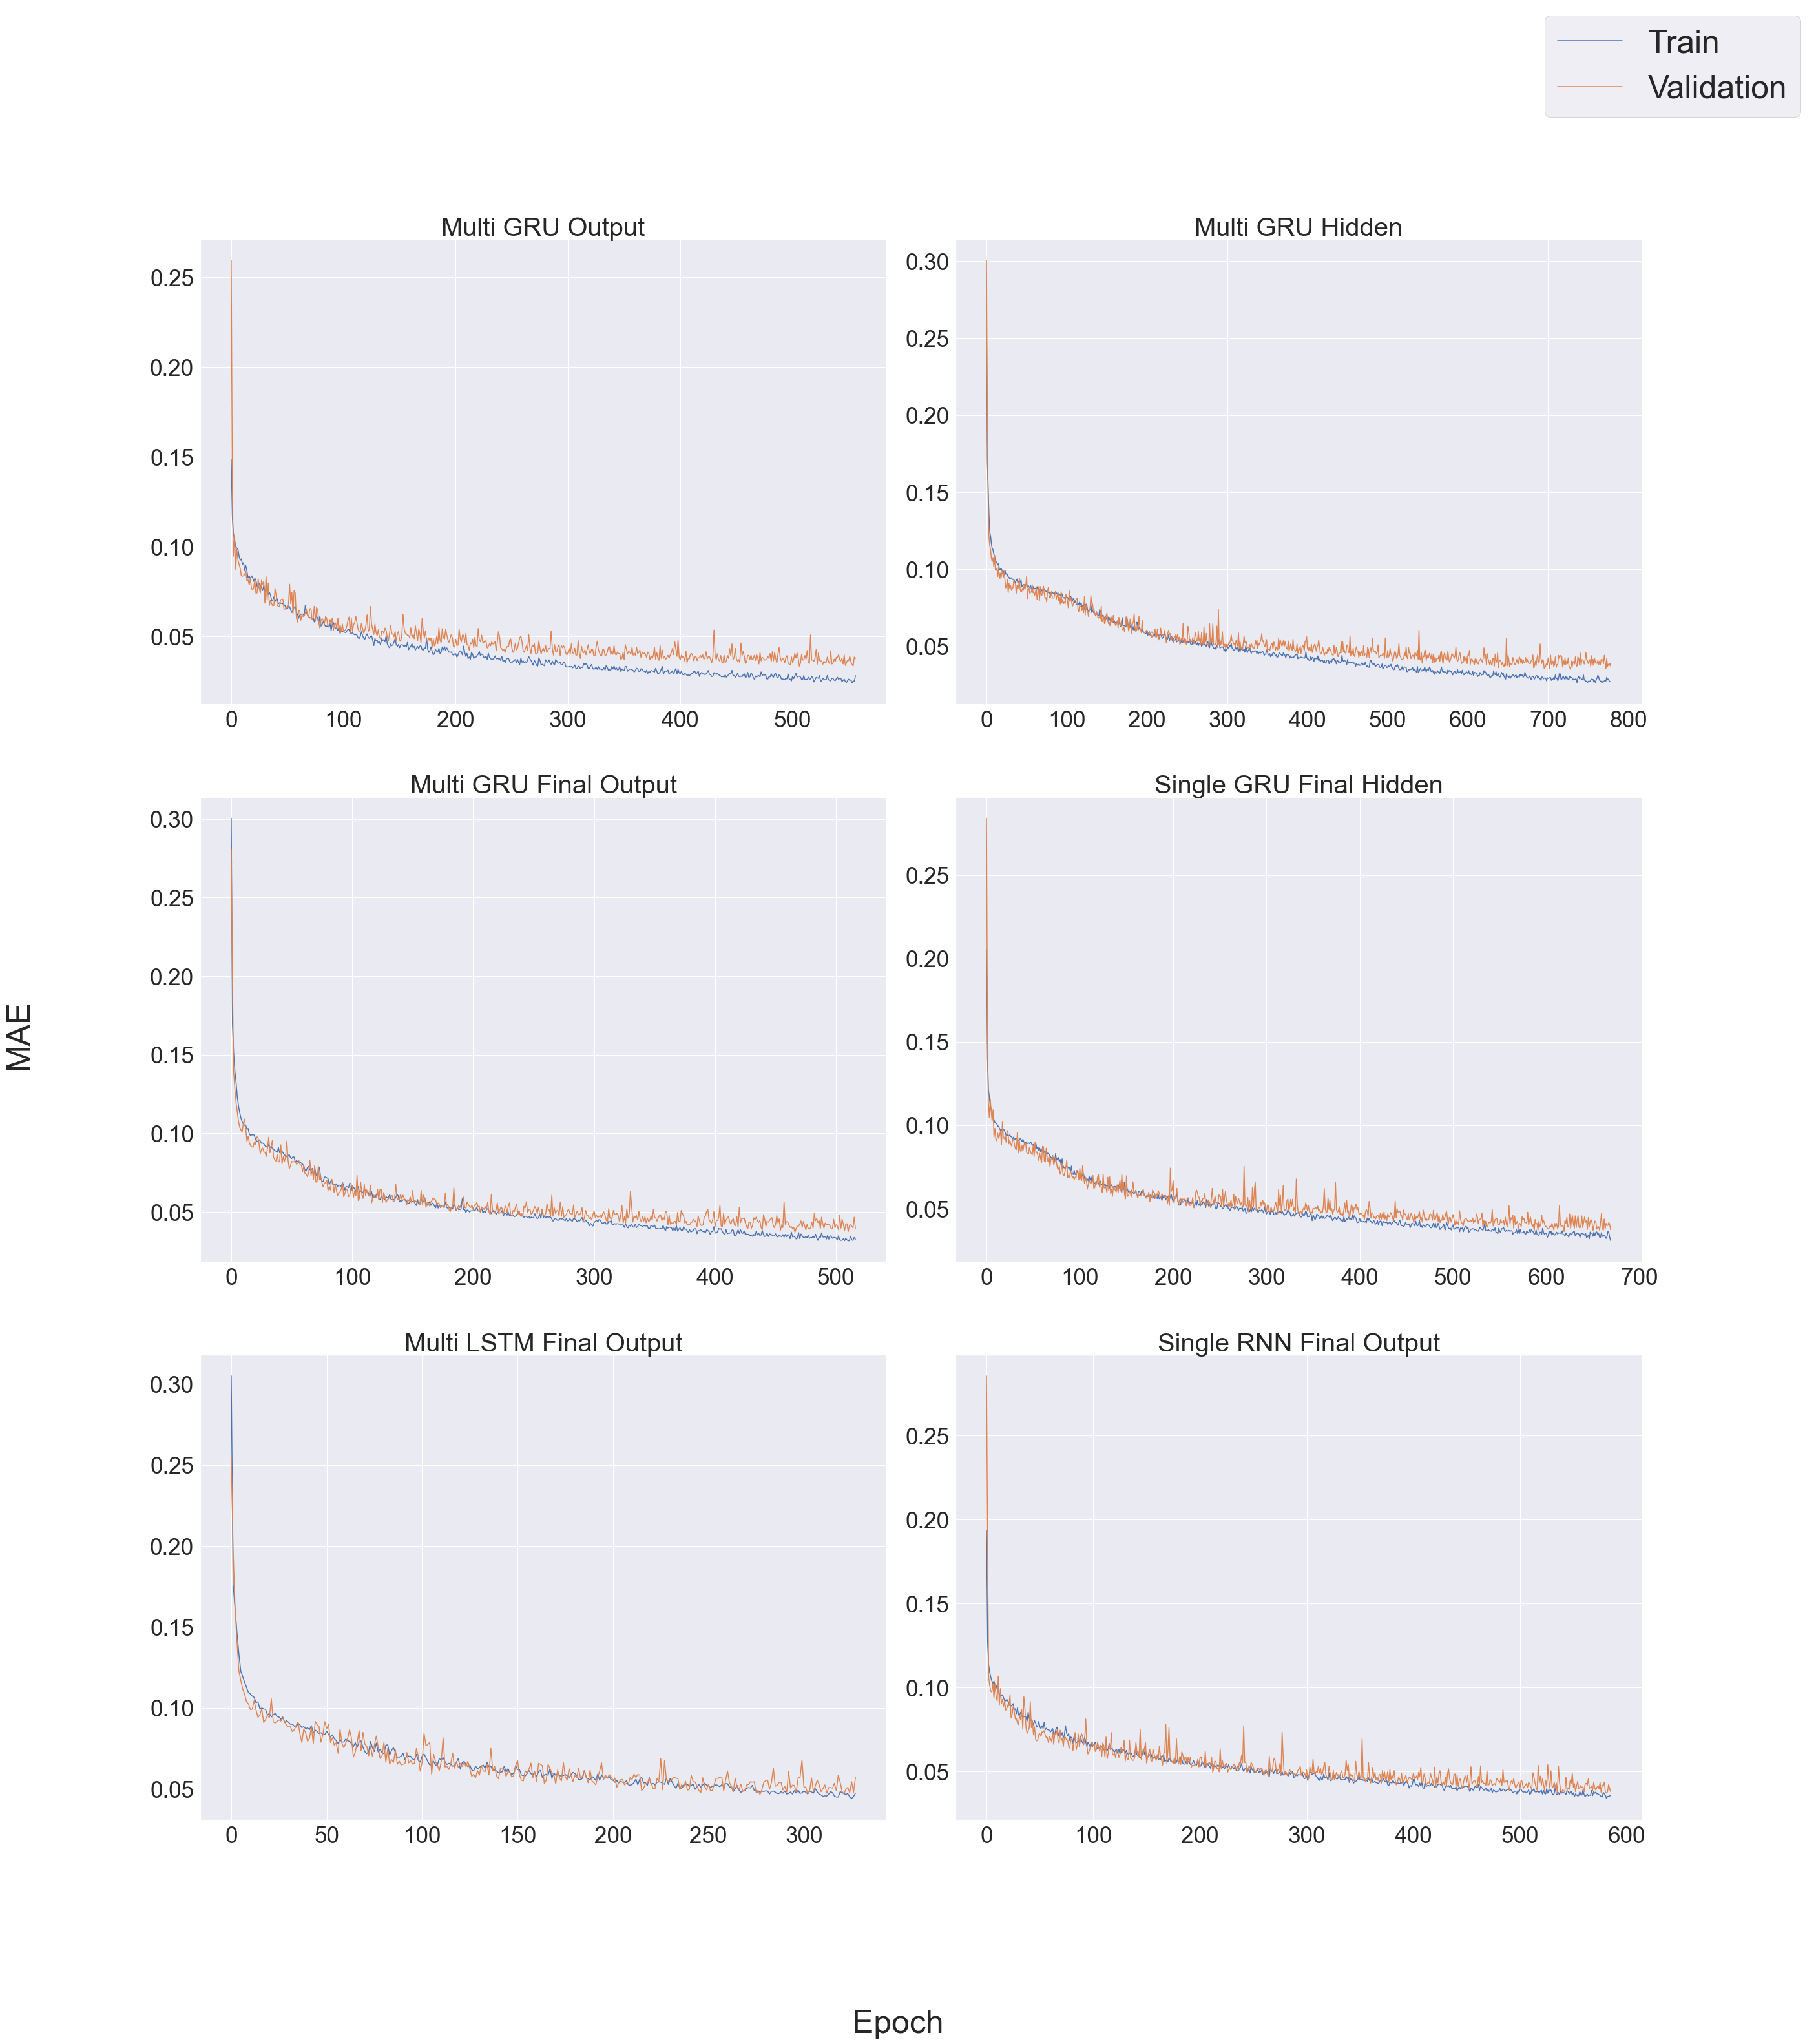

In [103]:
printCurves(names, trains, vals, epochs, fname="multtests")